# Baselines

In [1]:
#cell 1: imports + project paths
from pathlib import Path
import numpy as np
import pandas as pd

cwd = Path.cwd().resolve()
project_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "data").exists():
        project_root = p
        break
if project_root is None:
    raise RuntimeError("Project root not found: missing /data folder")

DATA_DIR = project_root / "data"
PROC_DIR = DATA_DIR / "processed"

panel_path = PROC_DIR / "modeling_panel_targets.parquet"
print("project_root:", project_root)
print("panel_path:", panel_path)


project_root: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor
panel_path: /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/modeling_panel_targets.parquet


In [ ]:
#cell 2: load + filter AAPL + clean column names
df = pd.read_parquet(panel_path)
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(["ticker", "date"]).reset_index(drop=True)
df = df[df["ticker"] == "AAPL"].copy()
df = df.sort_values("date").reset_index(drop=True)

#fix repeated substring in exog lag columns
df.columns = (
    pd.Index(df.columns)
    .str.replace("_logret_laglogret_lag", "_logret_lag", regex=False)
)

#drop all columns related to other tickers
cols_to_drop = [col for col in df.columns if col.startswith(("MSFT_", "GOOG_", "AMZN_"))]
df = df.drop(columns=cols_to_drop)

print("AAPL df shape:", df.shape)
df.head(3)


AAPL df shape: (3285, 286)


,date,ticker,Open,High,Low,Close,Adj Close,Volume,adj_close,logret_1d,...,^VIX_logret_lag19,AAPL_logret_lag20,CL=F_logret_lag20,GC=F_logret_lag20,QQQ_logret_lag20,SPY_logret_lag20,UUP_logret_lag20,XLK_logret_lag20,^TNX_logret_lag20,^VIX_logret_lag20
0,2013-01-02,AAPL,19.779285,19.821428,19.343929,19.608213,16.612209,560518000.0,16.612209,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,AAPL,19.567142,19.631071,19.321428,19.360714,16.402523,352965200.0,16.402523,-0.012703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,AAPL,19.177500,19.236786,18.779642,18.821428,15.945646,594333600.0,15.945646,-0.028249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#print all columns with NaN values and counts in descending
print("Columns with NaN values:")
print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False))

Columns with NaN values:
logret_1d_lag60     61
logret_1d_lag59     60
ret_mean_60         60
ret_vol_60          60
logret_1d_lag58     59
                    ..
AAPL_logret_lag1     2
vol_change           1
ret_1d               1
target_logret_1d     1
logret_1d            1
Length: 266, dtype: int64


In [22]:
#print the column names
print("Column names:")
print(df.columns.tolist())

Column names:
['date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'adj_close', 'logret_1d', 'ret_1d', 'target_logret_1d', 'hl_range', 'oc_change', 'ret_mean_5', 'ret_vol_5', 'ret_mean_10', 'ret_vol_10', 'ret_mean_20', 'ret_vol_20', 'ret_mean_60', 'ret_vol_60', 'sma_5', 'sma_10', 'sma_20', 'sma_60', 'sma_spread_5', 'sma_spread_20', 'sma_spread_60', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_hist', 'rsi_14', 'bb_mid_20', 'bb_std_20', 'bb_upper_20', 'bb_lower_20', 'bb_width_20', 'vol_change', 'vol_z_20', 'obv', 'dow', 'month', 'is_month_end', 'logret_1d_lag1', 'logret_1d_lag2', 'logret_1d_lag3', 'logret_1d_lag4', 'logret_1d_lag5', 'logret_1d_lag6', 'logret_1d_lag7', 'logret_1d_lag8', 'logret_1d_lag9', 'logret_1d_lag10', 'logret_1d_lag11', 'logret_1d_lag12', 'logret_1d_lag13', 'logret_1d_lag14', 'logret_1d_lag15', 'logret_1d_lag16', 'logret_1d_lag17', 'logret_1d_lag18', 'logret_1d_lag19', 'logret_1d_lag20', 'logret_1d_lag21', 'logret_1d_lag22', 'logret_1d_lag23'

In [4]:
#cell 3: define X/y and time split
TARGET = "target_logret_1d"

drop_cols = {
    "date", "ticker",
    TARGET,
}

#keep numeric predictors only
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c not in drop_cols]

#drop rows with missing target or missing features
model_df = df[["date", TARGET] + feature_cols].dropna().reset_index(drop=True)

n = len(model_df)
split_idx = int(n * 0.80)

train_df = model_df.iloc[:split_idx].copy()
test_df  = model_df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df[TARGET].copy()

print("model_df shape:", model_df.shape)
print("train rows:", len(train_df), "test rows:", len(test_df))
print("train date range:", train_df["date"].min(), "to", train_df["date"].max())
print("test  date range:", test_df["date"].min(), "to", test_df["date"].max())


model_df shape: (3097, 285)
train rows: 2477 test rows: 620
train date range: 2013-04-02 00:00:00 to 2023-06-01 00:00:00
test  date range: 2023-06-02 00:00:00 to 2026-01-22 00:00:00


In [5]:
#cell 4: feature ranking diagnostics (train only)
from sklearn.feature_selection import mutual_info_regression

corr = pd.concat([X_train, y_train], axis=1).corr(numeric_only=True)[TARGET].drop(TARGET)
corr_rank = corr.abs().sort_values(ascending=False).head(25)

mi = mutual_info_regression(X_train.values, y_train.values, random_state=42)
mi_rank = pd.Series(mi, index=feature_cols).sort_values(ascending=False).head(25)

print("Top 25 by |corr|")
display(corr_rank.to_frame("abs_corr"))

print("Top 25 by mutual information")
display(mi_rank.to_frame("mi"))


Top 25 by |corr|


,abs_corr
XLK_logret_lag7,0.108424
QQQ_logret_lag7,0.107897
SPY_logret_lag7,0.107107
XLK_logret_lag6,0.103955
logret_1d_lag7,0.097293
AAPL_logret_lag7,0.097293
SPY_logret_lag6,0.097103
QQQ_logret_lag6,0.096027
SPY_logret_lag8,0.090016
QQQ_logret_lag14,0.086478


Top 25 by mutual information


,mi
ret_vol_10,0.058560
hl_range,0.055978
ret_1d,0.055113
logret_1d,0.053923
sma_5,0.051344
macd,0.047551
High,0.038625
rsi_14,0.035834
^VIX_logret_lag4,0.034488
Close,0.032971


In [6]:
#cell 5: PCA explained variance diagnostic
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train.values)
X_test_s  = scaler.transform(X_test.values)

pca = PCA(n_components=0.80, svd_solver="full")
X_train_p = pca.fit_transform(X_train_s)
X_test_p  = pca.transform(X_test_s)

print("PCA components for 80% variance:", pca.n_components_)
print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())


PCA components for 80% variance: 91
Explained variance ratio sum: 0.8022804105397852


In [7]:
#print the columns in X_train_p
pca_columns = [f"pca_{i+1}" for i in range(pca.n_components_)]
print("PCA feature columns:", pca_columns)

PCA feature columns: ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49', 'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56', 'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63', 'pca_64', 'pca_65', 'pca_66', 'pca_67', 'pca_68', 'pca_69', 'pca_70', 'pca_71', 'pca_72', 'pca_73', 'pca_74', 'pca_75', 'pca_76', 'pca_77', 'pca_78', 'pca_79', 'pca_80', 'pca_81', 'pca_82', 'pca_83', 'pca_84', 'pca_85', 'pca_86', 'pca_87', 'pca_88', 'pca_89', 'pca_90', 'pca_91']


In [8]:
#cell: PCA loadings (which original features drive each component)
loadings = pd.DataFrame(
    pca.components_,
    columns=feature_cols,
    index=[f"pca_{i+1}" for i in range(pca.n_components_)]
)

def top_loadings(component_name, k=10):
    s = loadings.loc[component_name].abs().sort_values(ascending=False).head(k)
    return s

print("Top 10 original features for pca_1")
display(top_loadings("pca_1", 10).to_frame("abs_loading"))

print("Top 10 original features for pca_2")
display(top_loadings("pca_2", 10).to_frame("abs_loading"))


Top 10 original features for pca_1


,abs_loading
bb_upper_20,0.241004
ema_12,0.240628
sma_10,0.240588
ema_26,0.240551
sma_20,0.240532
bb_mid_20,0.240532
sma_5,0.240531
High,0.240523
Open,0.240417
adj_close,0.240411


Top 10 original features for pca_2


,abs_loading
sma_spread_20,0.274255
ret_mean_20,0.270796
rsi_14,0.265498
sma_spread_60,0.261440
ret_mean_10,0.243044
macd,0.224651
ret_mean_5,0.197022
macd_signal,0.185618
ret_mean_60,0.183355
sma_spread_5,0.165674


In [9]:
#cell 6: metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mda(y_true, y_pred):
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    true_dir = (yt > 0).astype(int)
    pred_dir = (yp > 0).astype(int)
    return float(np.mean(true_dir == pred_dir))

def eval_metrics(y_true, y_pred):
    return {
        "MAE":  float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2":   float(r2_score(y_true, y_pred)),
        "MDA":  float(mda(y_true, y_pred)),
    }


In [10]:
#cell 7: naive baseline
y_pred_naive = np.zeros_like(y_test.values)
naive_scores = eval_metrics(y_test.values, y_pred_naive)
print("Naive scores:", naive_scores)


Naive scores: {'MAE': 0.010954111745026527, 'RMSE': 0.016340645217930917, 'R2': -0.0013970740848519014, 'MDA': 0.45645161290322583}


In [12]:
#cell 8: ARIMA baseline
try:
    import pmdarima as pm
except Exception as e:
    raise RuntimeError("Install pmdarima to run ARIMA: pip install pmdarima") from e

arima = pm.auto_arima(
    y_train.values,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
)

y_pred_arima = arima.predict(n_periods=len(y_test))
arima_scores = eval_metrics(y_test.values, y_pred_arima)
print("ARIMA scores:", arima_scores)


/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/ut

ARIMA scores: {'MAE': 0.010946380855168978, 'RMSE': 0.01633793581194393, 'R2': -0.0010650227787258881, 'MDA': 0.5209677419354839}


/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
#cell 9: ARIMAX baseline using top MI features as exog
top_k = 20
top_exog = corr_rank.index[:top_k].tolist()

Xtr_exog = X_train[top_exog].values
Xte_exog = X_test[top_exog].values

arimax = pm.auto_arima(
    y_train.values,
    X=Xtr_exog,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",nput (look-back 60) → LSTM(128) → GRU(128) → Dense(64) → Dense(32) → Output(1) 
)

y_pred_arimax = arimax.predict(n_periods=len(y_test), X=Xte_exog)
arimax_scores = eval_metrics(y_test.values, y_pred_arimax)
print("ARIMAX scores:", arimax_scores)
print("ARIMAX exog features:", top_exog)


/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/ut

ARIMAX scores: {'MAE': 0.011260273230342083, 'RMSE': 0.01657921501184648, 'R2': -0.030850875505484154, 'MDA': 0.5225806451612903}
ARIMAX exog features: ['XLK_logret_lag7', 'QQQ_logret_lag7', 'SPY_logret_lag7', 'XLK_logret_lag6', 'logret_1d_lag7', 'AAPL_logret_lag7', 'SPY_logret_lag6', 'QQQ_logret_lag6', 'SPY_logret_lag8', 'QQQ_logret_lag14', 'logret_1d_lag8', 'AAPL_logret_lag8', 'SPY_logret_lag14', 'XLK_logret_lag8', 'XLK_logret_lag14', 'SPY_logret_lag5', 'logret_1d_lag6', 'AAPL_logret_lag6', 'XLK_logret_lag5', 'QQQ_logret_lag8']


/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/media/workhorse/Windows/MyWorkPlace/ml_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
#cell 10: XGBoost baseline
try:
    from xgboost import XGBRegressor
except Exception as e:
    raise RuntimeError("Install xgboost to run this baseline: pip install xgboost") from e

xgb = XGBRegressor(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
)

xgb.fit(X_train[top_exog], y_train)

y_pred_xgb = xgb.predict(X_test[top_exog])
xgb_scores = eval_metrics(y_test.values, y_pred_xgb)
print("XGBoost scores:", xgb_scores)


XGBoost scores: {'MAE': 0.01197544811987241, 'RMSE': 0.01742389532156475, 'R2': -0.1385665565261196, 'MDA': 0.4967741935483871}


In [15]:
#cell 11: baseline comparison table
results = pd.DataFrame([
    {"model": "Naive",  **naive_scores},
    {"model": "ARIMA",  **arima_scores},
    {"model": "ARIMAX", **arimax_scores},
    {"model": "XGBoost",**xgb_scores},
]).set_index("model")

print(results)

              MAE      RMSE        R2       MDA
model                                          
Naive    0.010954  0.016341 -0.001397  0.456452
ARIMA    0.010946  0.016338 -0.001065  0.520968
ARIMAX   0.011260  0.016579 -0.030851  0.522581
XGBoost  0.011975  0.017424 -0.138567  0.496774


  0%|          | 0/620 [00:00<?, ?it/s]

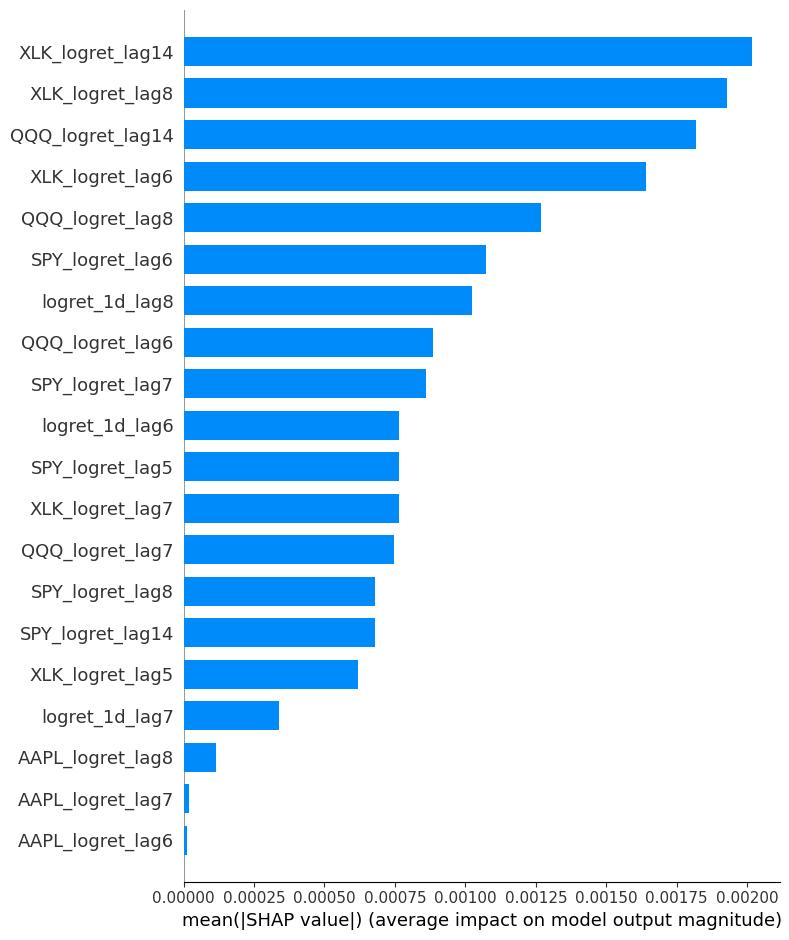

In [ ]:
#cell 12: SHAP feature importance for XGBoost
try:
    import shap
except Exception as e:
    raise RuntimeError("Install shap to run explanations: pip install shap") from e

# Use KernelExplainer to avoid XGBoost base_score parsing issues
X_shap = X_test[top_exog].copy()  # Use smaller subset for faster computation
background = shap.sample(X_train[top_exog], 50)

explainer = shap.KernelExplainer(
    model=lambda x: xgb.predict(x),
    data=background
)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, plot_type="bar")


In [19]:
#cell: Ridge baseline on PCA features
from sklearn.linear_model import Ridge

pca_feature_cols = [f"pca_{i+1}" for i in range(pca.n_components_)]
Xtr_pca = pd.DataFrame(X_train_p, columns=pca_feature_cols, index=train_df.index)
Xte_pca = pd.DataFrame(X_test_p,  columns=pca_feature_cols, index=test_df.index)

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(Xtr_pca, y_train)

y_pred_ridge_pca = ridge.predict(Xte_pca)
ridge_pca_scores = eval_metrics(y_test.values, y_pred_ridge_pca)
print("Ridge(PCA) scores:", ridge_pca_scores)


Ridge(PCA) scores: {'MAE': 0.011674973224949354, 'RMSE': 0.016944524950884214, 'R2': -0.07677933385258373, 'MDA': 0.4935483870967742}


In [20]:
#adapting XGBoost to PCA features
xgb_pca = XGBRegressor(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
)
xgb_pca.fit(Xtr_pca, y_train)
y_pred_xgb_pca = xgb_pca.predict(Xte_pca)
xgb_pca_scores = eval_metrics(y_test.values, y_pred_xgb_pca)
print("XGBoost(PCA) scores:", xgb_pca_scores)

XGBoost(PCA) scores: {'MAE': 0.01169644795483047, 'RMSE': 0.016795163559493443, 'R2': -0.05787996348491964, 'MDA': 0.5016129032258064}


In [21]:
#Improving XGBoost further with hyperparameter tuning on PCA features
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [500, 800],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.03, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0],
}
xgb_pca_gs = XGBRegressor(random_state=42)
gs = GridSearchCV(
    estimator=xgb_pca_gs,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
)
gs.fit(Xtr_pca, y_train)
print("Best hyperparameters:", gs.best_params_)
y_pred_xgb_pca_gs = gs.predict(Xte_pca)
xgb_pca_gs_scores = eval_metrics(y_test.values, y_pred_xgb_pca_gs)
print("XGBoost(PCA, tuned) scores:", xgb_pca_gs_scores)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 2.0, 'subsample': 0.8}
XGBoost(PCA, tuned) scores: {'MAE': 0.01107517754457305, 'RMSE': 0.016321468990416824, 'R2': 0.0009518846270607506, 'MDA': 0.5290322580645161}


In [23]:
#adapting XGBoost to PCA features
xgb_pca = XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_lambda=2.0,
    random_state=42,
)
xgb_pca.fit(Xtr_pca, y_train)
y_pred_xgb_pca = xgb_pca.predict(Xte_pca)
xgb_pca_scores = eval_metrics(y_test.values, y_pred_xgb_pca)
print("XGBoost(PCA) scores:", xgb_pca_scores)

XGBoost(PCA) scores: {'MAE': 0.01107517754457305, 'RMSE': 0.016321468990416824, 'R2': 0.0009518846270607506, 'MDA': 0.5290322580645161}


In [25]:
# Save all metrics to CSV
metrics_df = pd.DataFrame([
    {"model": "Naive", **naive_scores},
    {"model": "ARIMA", **arima_scores},
    {"model": "ARIMAX", **arimax_scores},
    {"model": "XGBoost", **xgb_scores},
    {"model": "Ridge_PCA", **ridge_pca_scores},
    {"model": "XGBoost_PCA", **xgb_pca_scores},
    {"model": "XGBoost_PCA_Tuned", **xgb_pca_gs_scores},
])

# Save to CSV
output_path = PROC_DIR / "phase1_metrics.csv"
metrics_df.to_csv(output_path, index=False)
print(f"Metrics saved to {output_path}")
print("\nMetrics summary:")
print(metrics_df)

Metrics saved to /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase1_metrics.csv

Metrics summary:
               model       MAE      RMSE        R2       MDA
0              Naive  0.010954  0.016341 -0.001397  0.456452
1              ARIMA  0.010946  0.016338 -0.001065  0.520968
2             ARIMAX  0.011260  0.016579 -0.030851  0.522581
3            XGBoost  0.011975  0.017424 -0.138567  0.496774
4          Ridge_PCA  0.011675  0.016945 -0.076779  0.493548
5        XGBoost_PCA  0.011075  0.016321  0.000952  0.529032
6  XGBoost_PCA_Tuned  0.011075  0.016321  0.000952  0.529032


In [26]:
# Save preprocessing artifacts for reuse in other files
import joblib

preprocessing_artifacts = {
    "scaler": scaler,
    "pca": pca,
    "feature_cols": feature_cols,
    "target_col": TARGET,
    "top_exog": top_exog,
    "pca_feature_cols": pca_feature_cols,
    "drop_cols": list(drop_cols),
}

artifacts_path = PROC_DIR / "phase1_preprocessing_artifacts.joblib"
joblib.dump(preprocessing_artifacts, artifacts_path)
print(f"Preprocessing artifacts saved to {artifacts_path}")
print("\nSaved artifacts:")
for key, value in preprocessing_artifacts.items():
    if isinstance(value, list):
        print(f"  - {key}: list with {len(value)} items")
    else:
        print(f"  - {key}: {type(value).__name__}")

Preprocessing artifacts saved to /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase1_preprocessing_artifacts.joblib

Saved artifacts:
  - scaler: StandardScaler
  - pca: PCA
  - feature_cols: list with 283 items
  - target_col: str
  - top_exog: list with 20 items
  - pca_feature_cols: list with 91 items
  - drop_cols: list with 3 items


In [ ]:
# Save SHAP values and corresponding data

shap_data = {
    "shap_values": shap_values,
    "X_shap": X_shap.values,
    "X_shap_columns": X_shap.columns.tolist(),
    "X_shap_index": X_shap.index.tolist(),
}

shap_path = PROC_DIR / "phase1_shap_values.npz"
np.savez(shap_path, **shap_data)
print(f"SHAP values saved to {shap_path}")
print(f"\nShape of SHAP values: {shap_values.shape}")
print(f"Shape of X_shap: {X_shap.shape}")
print(f"Features: {len(X_shap.columns)}")

SHAP values saved to /media/workhorse/Windows/MyWorkPlace/Projects/StockPredictor/data/processed/phase1_shap_values.npz

Shape of SHAP values: (620, 20)
Shape of X_shap: (620, 20)
Features: 20
